In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def DoRotation3D(xspan, yspan, zspan, RotRadX=0, RotRadY=0, RotRadZ=0):
    """Generate a 3D meshgrid and rotate it by RotRadX, RotRadY, and RotRadZ radians."""

    # Rotation matrices for x, y, and z axes
    RotMatrixX = np.array([[1, 0, 0],
                           [0, np.cos(RotRadX), -np.sin(RotRadX)],
                           [0, np.sin(RotRadX), np.cos(RotRadX)]])
    
    RotMatrixY = np.array([[np.cos(RotRadY), 0, np.sin(RotRadY)],
                           [0, 1, 0],
                           [-np.sin(RotRadY), 0, np.cos(RotRadY)]])
    
    RotMatrixZ = np.array([[np.cos(RotRadZ), -np.sin(RotRadZ), 0],
                           [np.sin(RotRadZ), np.cos(RotRadZ), 0],
                           [0, 0, 1]])

    # Combined rotation matrix
    RotMatrix = RotMatrixZ @ RotMatrixY @ RotMatrixX

    # Create a 3D meshgrid
    x, y, z = np.meshgrid(xspan, yspan, zspan, indexing='ij')

    # Stack the meshgrid arrays into a single 4D array
    grid = np.stack([x, y, z], axis=-1)

    # Apply the rotation matrix
    rotated_grid = np.einsum('ij,klmj->klmi', RotMatrix, grid)

    return rotated_grid

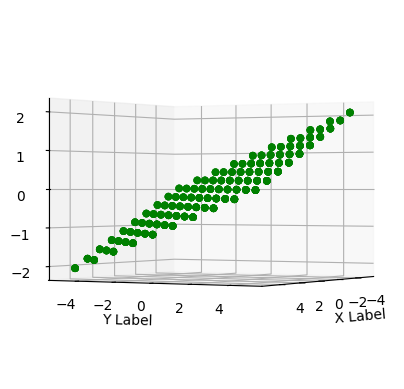

In [3]:
w = 10
sources = 10
x = np.linspace(-w/2, w/2, sources)
y = np.linspace(-w/2, w/2, sources)
z = np.zeros_like(x)

tilt_angle = np.deg2rad(12)
rotated_mesh = DoRotation3D(x, y, z, RotRadX=tilt_angle, RotRadY=tilt_angle, RotRadZ=0)

# Extract the rotated coordinates
x_rot = rotated_mesh[..., 0]
y_rot = rotated_mesh[..., 1]
z_rot = rotated_mesh[..., 2]

# Plotting the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_rot, y_rot, z_rot, c='g', marker='o')

# Set view angle to look from the top
ax.view_init(elev=0, azim=30)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [4]:
w = 10
g = 1
sources = 10
mirrors = 5
dmd_size = (w+g)*mirrors - g

# field parameters
field_dimensions = (200, 200)
res = 1  # number of pixels for a single field dimension point
pixels_x = res * field_dimensions[0]  # total number of pixels in x-direction
pixels_y = res * field_dimensions[1]  # total number of pixels in y-direction

# define the range where the field should be calculated
x_range = np.linspace(-field_dimensions[0]/2, field_dimensions[0]/2, pixels_x)
z_range = np.linspace(0, field_dimensions[1], pixels_y) - w/2
X, Z = np.meshgrid(x_range, z_range)
Y = np.zeros_like(X)

x = np.linspace(-w/2, w/2, sources)
y = np.linspace(-w/2, w/2, sources)
z = np.zeros_like(x)

tilt_angle = np.deg2rad(12)
xy_tilt_angle = np.deg2rad(45)
rotated_mesh = DoRotation3D(x, y, z, RotRadX=tilt_angle, RotRadY=0, RotRadZ=xy_tilt_angle)

# incident wave parameters
wl = 1
k = 2*np.pi/wl
incident_angle = np.deg2rad(30)
k_wave = - k * np.array([
    np.sin(incident_angle)*np.cos(0),
    np.sin(incident_angle)*np.sin(0),
    np.cos(incident_angle)
])

# projection along x-axis
x_unit = np.array([1, 0, 0])
# y_unit = np.
k_x = np.dot(k_wave, x_unit)*x_unit

# projection along mirror
# TODO: projection along mirror plane

coords = np.zeros((mirrors, mirrors, 3, sources, sources, sources))
epsilon0 = 1e-10
E_total = np.zeros_like(X, dtype=complex)

z_rot = rotated_mesh[..., 2]
for i in range(mirrors):
    x_rot = rotated_mesh[..., 0] + (w+g)*i - dmd_size/2 + w/2
    for j in range(mirrors):
        # Extract the rotated coordinates
        y_rot = rotated_mesh[..., 1] + (w+g)*j - dmd_size/2 + w/2
        coords[i, j, 0] = x_rot
        coords[i, j, 1] = y_rot
        coords[i, j, 2] = z_rot
        # print("x_rot", x_rot[0])

        for sx in range(sources):
            for sy in range(sources):
                x_coord = coords[i, j, 0, 0, sx, sy]
                y_coord = coords[i, j, 1, 0, sx, sy]
                z_coord = coords[i, j, 2, 0, sx, sy]
                r = np.sqrt(np.square(X - x_coord) + np.square(Y - y_coord) + np.square(Z - z_coord))
                E_total += np.exp(1j * (k * r))/(r + epsilon0)

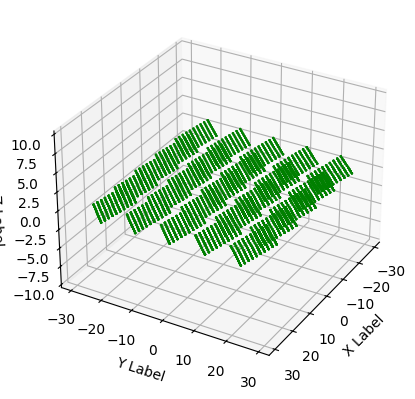

In [5]:
# Plotting the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x_all = [coords[i, j, 0] for i in range(mirrors) for j in range(mirrors)]
y_all = [coords[i, j, 1] for i in range(mirrors) for j in range(mirrors)]
z_all = [coords[i, j, 2] for i in range(mirrors) for j in range(mirrors)]
ax.scatter(x_all, y_all, z_all, c='g', marker='o', s=0.5)

# Set view angle to look from the top
ax.view_init(elev=30, azim=30)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_zlim3d(-10, 10)

plt.show()

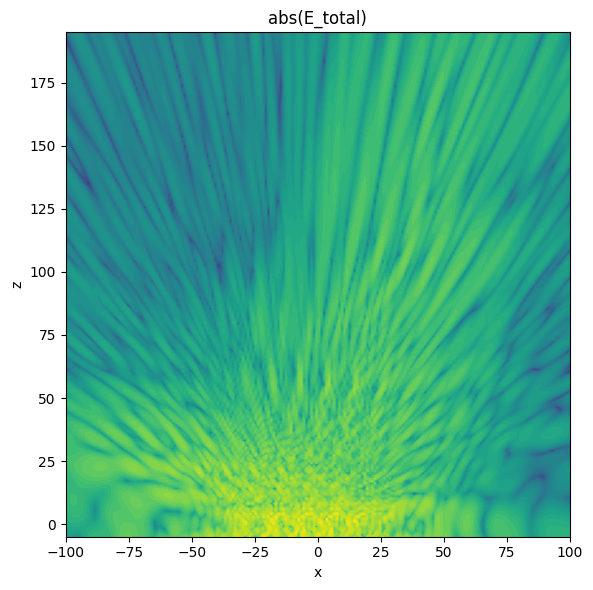

In [6]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot the real part of the total reflected field
plt.contourf(X, Z, np.log(np.abs(E_total)), levels=50, cmap='viridis')
plt.title('abs(E_total)')
plt.xlabel('x')
plt.ylabel('z')
plt.axis("square")

plt.tight_layout()
plt.show()